In [72]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
matplotlib.style.use('ggplot')


user = 'mara/personnel/vittal'
password = '0099-4aca'

#n_plans = 100
maxTime = '2017-08-31T00%3A00%3A00.000%2B0000'
minTime = '2017-08-30T00%3A00%3A00.000%2B0000'

#url_format_batches = 'https://api.locus-api.com/v1//client/{client_id}/batch/?limit={n_plans}&maxTime={maxTime}&minTime={minTime}'.format(
#	client_id = '{client_id}',
#	n_plans = n_plans,
#	maxTime = maxTime,
#	minTime = minTime
#)

url_format_batches = 'https://api.locus-api.com/v1//client/{client_id}/batch/?maxTime={maxTime}&minTime={minTime}'.format(
	client_id = '{client_id}',maxTime = maxTime,minTime = minTime)

url_format_batch_byid = 'https://locus-api.com/v1/client/{client_id}/batch/{batch_id}?include=TASKS'

url_format_plans = 'https://api.locus-api.com/v1//client/{client_id}/batch/{batch_id}/plan/'

plan_url_format = 'https://api.locus-api.com/v1//client/{client_id}/batch/{batch_id}/plan/{plan_id}?include=TOURS'

url_format_users = 'https://locus-api.com/v1/client/{client_id}/user'

class Requester:
	def __init__(self, user, password):
		self.user = user
		self.password = password
	
	def request(self, url):
		import requests
		
		response = requests.get(url, auth = (self.user, self.password))
		
		return response

requester = Requester(user, password)

client_ids = ['bigbasket']

RiderLatLngList = []
RiderLatLng ={}

for client_id in client_ids:
	FinalOutput = []
	url_batches = url_format_batches.format(client_id = client_id)
	
	response_batches = requester.request(url_batches)
	data_batches = response_batches.json()
	batches = data_batches['batches']

	for batch in batches:
		batch_id = batch['batchId']['batchId']
		batch_teams = batch['teamIds']
		team_ids = []
		for team in batch_teams:
			team_id = team['teamId']
			team_ids.append(team_id)
		
		team_ids_concat = ', '.join(team_ids)
		
		url_plans = url_format_plans.format(
			client_id = client_id,
			batch_id = batch_id
		)

		url_batch_byid = url_format_batch_byid.format(client_id = client_id,batch_id = batch_id)
		response_batch_byid = requester.request(url_batch_byid)
		
#Taking pincodes and locality name for each task and creating a dictionary

		data_batch_byid = response_batch_byid.json()
		tasks_data = data_batch_byid['tasks']
		task_loc = {}
		for task in tasks_data:
			task_id_loc ={}
			task_id = task['taskId']
			tasks_visit_data = task['taskGraph']['visits']
			for task_visit in tasks_visit_data:
				tasks_visit_loc = task_visit['locationOptions']
				for task_visit_loc in tasks_visit_loc:
					if task_visit_loc['id'] != 1:
						task_loc[task_id] = [
											task_visit_loc['locationAddress']['pincode'],
											task_visit_loc['locationAddress']['localityName'],
											(task_visit_loc['geometry']['latLng']['lat'],task_visit_loc['geometry']['latLng']['lng'])
												]
#Getting plan level data to link assigned rider for a given tour along with tasks

		response_plans = requester.request(url_plans)
		data_plans = response_plans.json()
		
		plans = data_plans['plans']
		
		for plan in plans:
			plan_id = plan['planId']['planId']
			plan_url = plan_url_format.format(
				client_id = client_id,
				batch_id = batch_id,
				plan_id = plan_id
			)
			response_planById = requester.request(plan_url)
			data_planById = response_planById.json()
			tour_data = data_planById["tours"]

			for tour in tour_data:
				try:
					rider_name = tour['assignedUser']['userId']
					visit_data = tour['visits']
					taskIds = []
					pincodes = []
					localityNames = []
					latLngs = []
					for visit in visit_data:
						tempList = []
						if visit['visitSource'] != 'USER' and visit['sourceId'] not in taskIds:
							taskIds.append(visit['sourceId'])
							pincodes.append(task_loc[visit['sourceId']][0])
							localityNames.append(task_loc[visit['sourceId']][1])
							latLngs.append(task_loc[visit['sourceId']][2])
					tempList = [{'ClientID':client_id},
										{'TeamID':team_ids_concat},
										{'RiderName':rider_name},
										{'TaskID':taskIds},
										{'Pincodes':pincodes},
										{'LocalityNames':localityNames},
										{'LatLng':latLngs}]
					FinalOutput.append(tempList)
				except TypeError:
					pass
	


#Organising data of latLng for each rider for a given client
	for item in FinalOutput:
		for pos in item[6]['LatLng']:
			RiderLatLng['ClientID'] = item[0]['ClientID']
			RiderLatLng['TeamID'] = item[1]['TeamID']
			RiderLatLng['UserID'] = item[2]['RiderName']
			RiderLatLng['Lat'] = pos[0]
			RiderLatLng['Lng'] = pos[1]
			RiderLatLngList.append(dict(RiderLatLng))
	
df = pd.DataFrame(RiderLatLngList)

SSLError: ("bad handshake: SysCallError(-1, 'Unexpected EOF')",)

In [4]:
cd Work/RiderSuggest/

/Users/vittalsirigiri/Work/RiderSuggest


In [73]:
df.to_csv('RiderLatLngFile_BigBasket.csv')

In [58]:
with open('RiderLatLngFile_BigBasket.csv','a') as f:
    df.to_csv(f, header=False)
#df.to_csv('RiderLatLngFile.csv')

In [75]:
df1 = pd.read_csv('RiderLatLngFile_BigBasket.csv')
ColorNames={}
names = df1['UserID'].unique()
for i in range(len(names)):
    ColorNames[names[i]] = (np.random.rand(),np.random.rand(),np.random.rand())
df1['Colors'] ='s'
for i in range(df1.shape[0]):
    df1.set_value(i,'Colors',ColorNames[df1.loc[i,'UserID']])

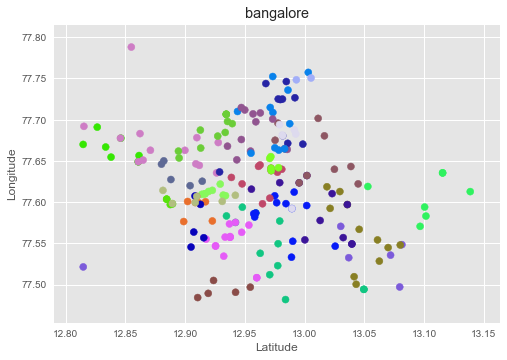

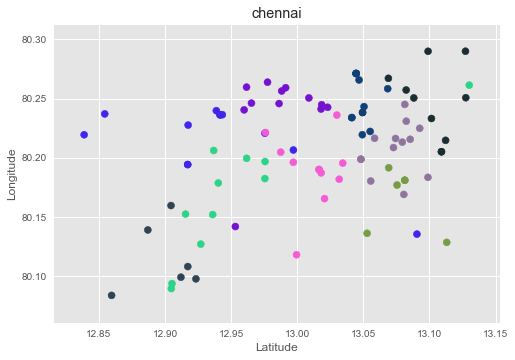

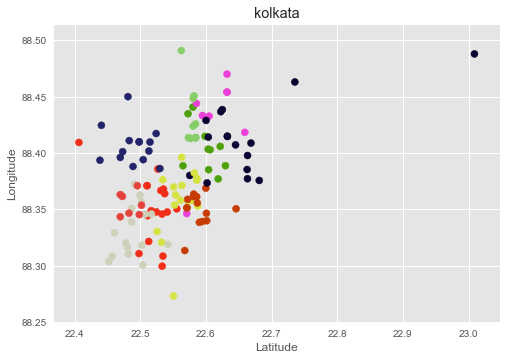

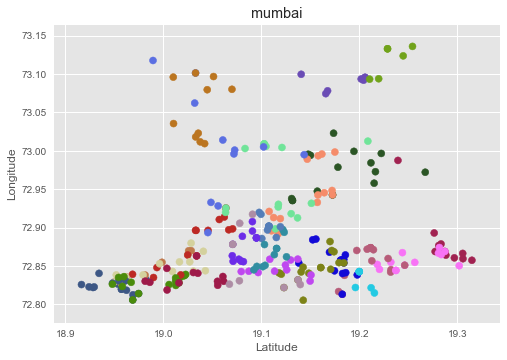

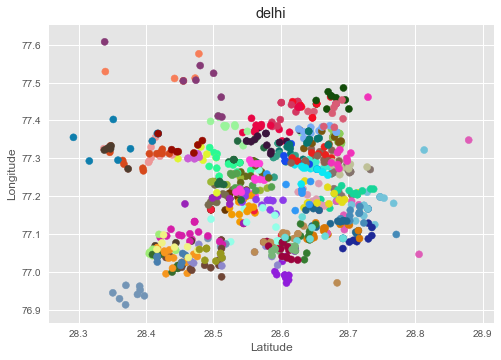

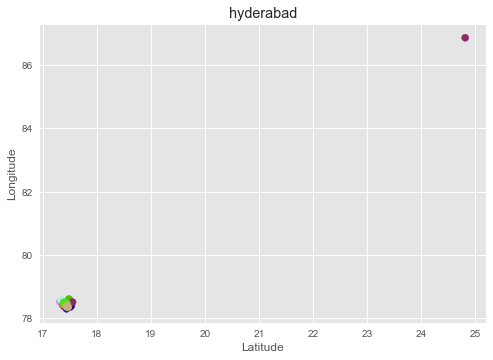

In [84]:
#Plotting Lat Longs for all riders in a given team. each rider is given a different color
for item in df1['TeamID'].unique():
    tempdf1 = df1[df1.TeamID==item]
    plt.scatter(tempdf1['Lat'],tempdf1['Lng'],color=tempdf1['Colors'])
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title(item)
    plt.show()

In [82]:
df2 = pd.read_csv('RiderLatLngFile.csv')
ColorNames={}
names = df2['UserID'].unique()
for i in range(len(names)):
    ColorNames[names[i]] = (np.random.rand(),np.random.rand(),np.random.rand())
df2['Colors'] ='s'
for i in range(df2.shape[0]):
    df2.set_value(i,'Colors',ColorNames[df2.loc[i,'UserID']])

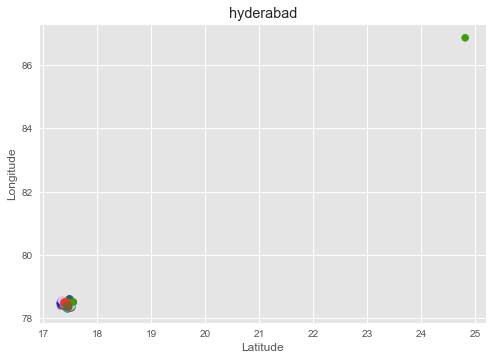

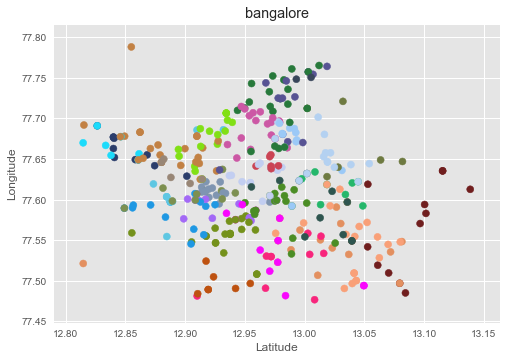

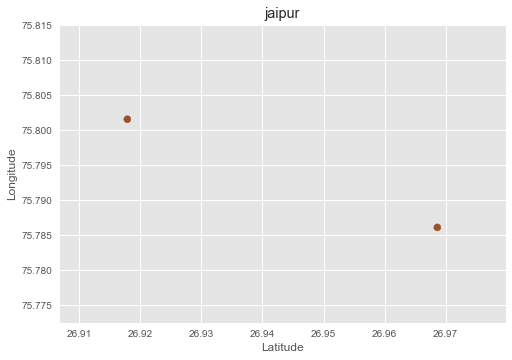

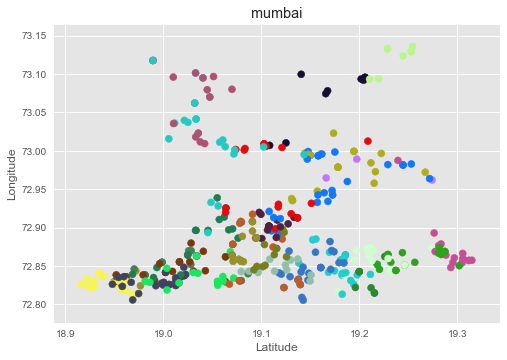

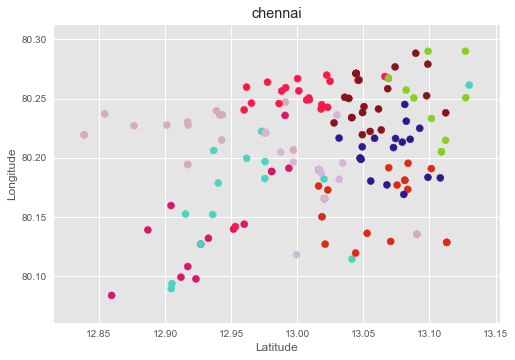

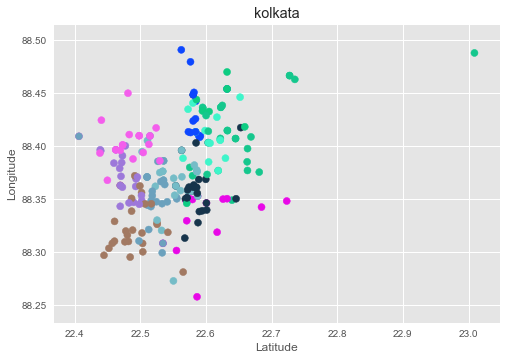

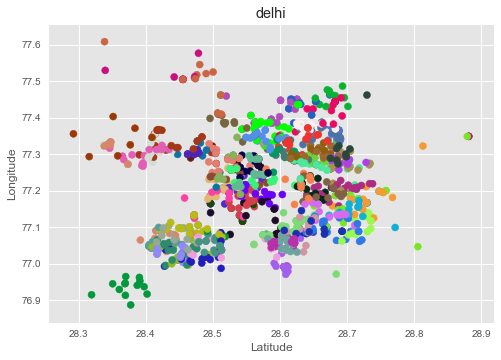

In [85]:
#Plotting Lat Longs for all riders in a given team. each rider is given a different color
for item in df2['TeamID'].unique():
    tempdf2 = df2[df2.TeamID==item]
    plt.scatter(tempdf2['Lat'],tempdf2['Lng'],color=tempdf2['Colors'])
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title(item)
    plt.show()

In [79]:
df1['TeamID'].unique()

array(['bangalore', 'chennai', 'kolkata', 'mumbai', 'delhi', 'hyderabad'], dtype=object)